In [211]:
#2/4 06:49
import numpy as np  
from numpy  import array
import pandas as pd
from keras.models import Sequential  
from keras.optimizers import RMSprop , Adam
from keras.layers import GaussianNoise, Dense , Conv2D , Activation , Dropout , Flatten , BatchNormalization , Reshape , UpSampling2D ,Conv2DTranspose,MaxPooling2D
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import np_utils
import h5py
import os
from os import listdir
from os.path import isfile, isdir, join
from keras import backend as K
from PIL import Image
import sys
import random
os.environ['CUDA_VISIBLE_DEVICES'] = '0'




In [212]:
batch_size = 128;

In [213]:
mypath = "fruit"
files = listdir(mypath)
label = 1
imglist = []
labellist= []
fruitname = []
for f in files:
    fullpath = join(mypath, f)
    print("目錄：", f)
    fruitname.append(f)
    files2 = listdir(fullpath)
    for f2 in files2:
        fullpath2 = join(fullpath, f2)
        img = Image.open(fullpath2)
        img = img.resize((64, 64), Image.ANTIALIAS)
        img = np.array(img)
        o = np.ones(img.shape)
        img = img - (o * 127.5) 
        img = img / 127.5
        img=img
        imglist.append(img)
        labellist.append(label)
    label = label + 1



目錄： Apple
目錄： Banana
目錄： Carambula
目錄： Cherry
目錄： Grape Pink
目錄： Grape White
目錄： Guava
目錄： Kiwi
目錄： Lemon
目錄： Litchi
目錄： Mandarine
目錄： Orange
目錄： Passion Fruit
目錄： Peach
目錄： Pear
目錄： Pineapple
目錄： Pitahaya Red
目錄： Plum
目錄： Pomegranate
目錄： Strawberry


In [214]:
combined = list(zip(imglist, labellist))
random.shuffle(combined)
imglist[:], labellist[:] = zip(*combined)
#print(imglist[1888])
#print(labellist[1888])

In [215]:
RealY = np_utils.to_categorical(labellist,num_classes=21)
RealY = RealY*0.85
RealY

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [216]:
#鑑定器 D
# In: 64 x 64 x 3, depth = 3
modelD = Sequential()

modelD.add(Conv2D(filters=32, strides=2 , kernel_size=(3, 3), padding='same', input_shape=(64, 64, 3)))
modelD.add(BatchNormalization())
modelD.add(LeakyReLU(0.2))

modelD.add(Conv2D(filters=64, strides=2 , kernel_size=(3, 3), padding='same'))
modelD.add(BatchNormalization())
modelD.add(LeakyReLU(0.2))

modelD.add(Conv2D(filters=128, strides=2 , kernel_size=(5, 5), padding='same'))
modelD.add(BatchNormalization())
modelD.add(LeakyReLU(0.2))

modelD.add(Conv2D(filters=256, strides=2 , kernel_size=(5, 5), padding='same'))
modelD.add(BatchNormalization())
modelD.add(LeakyReLU(0.2))
           
#modelD.add(Dropout(0.2))
modelD.add(Flatten())
modelD.add(Dense(21))
modelD.add(Activation('softmax'))
modelD.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
batch_normalization_52 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_53 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 128)         204928    
__________

In [217]:
#生成器 G
# In: 512
modelG = Sequential()
modelG.add(Dense(8*8*128, input_dim=120))
modelG.add(Activation('relu'))
#modelG.add(Dropout(0.3))
modelG.add(Reshape((8, 8, 128)))
modelG.add(Conv2DTranspose(128, kernel_size = (5,5), strides=(2, 2), padding='same'))
modelG.add(BatchNormalization())
modelG.add(Activation('relu'))

modelG.add(Conv2DTranspose(64, kernel_size = (5,5), strides=(2, 2), padding='same'))
modelG.add(BatchNormalization())
modelG.add(Activation('relu'))

modelG.add(Conv2DTranspose(32, kernel_size = (3,3), strides=(2, 2), padding='same'))
modelG.add(BatchNormalization())
modelG.add(Activation('relu'))

modelG.add(Conv2DTranspose(3, kernel_size = (3,3), strides=(1, 1), padding='same'))
#modelG.add(BatchNormalization())
modelG.add(Activation('tanh'))
modelG.add(Reshape((64, 64, 3)))
modelG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32768)             3964928   
_________________________________________________________________
activation_56 (Activation)   (None, 32768)             0         
_________________________________________________________________
reshape_20 (Reshape)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_39 (Conv2DT (None, 32, 32, 128)       409728    
_________________________________________________________________
batch_normalization_56 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
activation_57 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_40 (Conv2DT (None, 64, 64, 64)        73792     
__________

In [218]:
#D
optimizerD = Adam(0.0002, 0.5)
modelTD = Sequential()
modelTD.add(modelD)
modelTD.compile(loss='binary_crossentropy', optimizer=optimizerD,metrics=['accuracy'])
#A1
optimizerA = Adam(0.00015, 0.5)
modelTA = Sequential()
modelTA.add(modelG)
modelTA.add(modelTD)
modelTD.trainable = False
modelTA.compile(loss='binary_crossentropy', optimizer=optimizerA,metrics=['accuracy'])

In [219]:
a_loss_record = []
d_loss_record = []
dF_loss_record = []
dR_loss_record = []

In [220]:
def TrainG():
    Fake_Lable = np.random.randint(0, 20, batch_size)
    Fake_Lable = np_utils.to_categorical(Fake_Lable,num_classes=20)
    noise = np.random.uniform(-0.8, 0.8, size=[batch_size, 100]) 
    NT = np.hstack((Fake_Lable,noise))
    #YA = np.ones([batch_size, 1])
    #YA = YA  * 0.85
    YA = Fake_Lable * 0.85
    YA = np.hstack((np.zeros([batch_size, 1]),YA))
    a_loss = modelTA.train_on_batch(NT,YA)
    a_loss_record.append(a_loss[0])
    print ("A1")
    print (a_loss)
    return a_loss

In [221]:
def TrainD():
    Rnd = np.random.randint(0,len(imglist),size = int(batch_size/2))
    newimglist = []
    for a in Rnd:
        newimglist.append(imglist[a])
    RealX = np.asarray(newimglist)
    YA = RealY[Rnd]    
    #YA = np.ones([int(batch_size/2), 1])
    YA = YA  * 0.85
    
    YZ = np.zeros([int(batch_size/2), 1])
    YZ = np_utils.to_categorical(YZ,num_classes=21)
    YZ = YZ  * 0.85
    
    Fake_Lable = np.random.randint(0, 20, int(batch_size/2))
    Fake_Lable = np_utils.to_categorical(Fake_Lable,num_classes=20)
    noise = np.random.uniform(-0.8, 0.8, size=[int(batch_size/2), 100]) 
    NT = np.hstack((Fake_Lable,noise))
    
    FakeX = modelG.predict(NT)
                                             
    gauss = np.random.normal(0,0.25,(int(batch_size/2),64,64,3))
    RealGX = RealX + gauss
    gauss = np.random.normal(0,0.25,(int(batch_size/2),64,64,3))
    FakeGX = FakeX + gauss 

    d_lossR = modelTD.train_on_batch(RealGX, YA)
    print ("D1R")
    print (d_lossR)
    d_lossF = modelTD.train_on_batch(FakeGX, YZ)
    print ("D1F")
    print (d_lossF)
    #
    d_loss =  (d_lossR[0] +  d_lossF[0]) / 2
    d_loss_record.append(d_loss)
  #  print ("D")
  #  print (d_loss)
    dR_loss_record.append(d_lossR[0])
    dF_loss_record.append(d_lossF[0])
    return d_loss
    

In [222]:
def Show(path):
    Fake_Lable = np.random.randint(0, 20, 1)
    k = Fake_Lable[0]
    Fake_Lable = np_utils.to_categorical(Fake_Lable,num_classes=20)
    noise = np.random.uniform(-0.8, 0.8, size=[1, 100]) 
    NT = np.hstack((Fake_Lable,noise))                                       
    FakeX = modelG.predict(NT)
    img = FakeX[0]
    img = img.reshape(64,64,3)
    img = img * 0.5 + 0.5
    plt.figure(figsize=(5,5))
    
    plt.title(fruitname[k])
    plt.imshow(img)
    plt.savefig(path)
    plt.show()
   

In [223]:
def ShowPlt():
    plt.plot(d_loss_record,label="d_loss")
    plt.plot(a_loss_record,label="a_loss")
    plt.plot(dR_loss_record,label="dR_loss")
    plt.plot(dF_loss_record,label="dF_loss")
    plt.legend()
    plt.show()


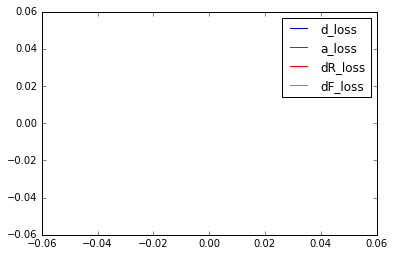

In [224]:
ShowPlt()

In [227]:
directory = 'img'
if not os.path.exists(directory):
    os.makedirs(directory)

In [225]:
for a in range(10000):
    print (a+0)
    TrainD()
    TrainG()
    if(a % 25 == 0):
        for b in range(3):
            name = 'img/'+str(a)+'-'+str(b)+'.png'
            Show(name)
        ShowPlt()

0


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\keras\engine\training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D1R
[0.17642756, 0.95163703]
D1F
[0.21631485, 0.95238107]
A1
[0.20331322, 0.95014894]


FileNotFoundError: [Errno 2] No such file or directory: 'img/0-0.png'

In [ ]:
modelTD.load_weights('modelTD5_weights.h5')
modelTA.load_weights('modelTA5_weights.h5')

In [ ]:
modelTD.save('modelDFruit.h5') 
modelTA.save('modelTFruit.h5') 
modelTD.save_weights('modelDFruit_weights.h5')
modelTA.save_weights('modelAFruit_weights.h5')


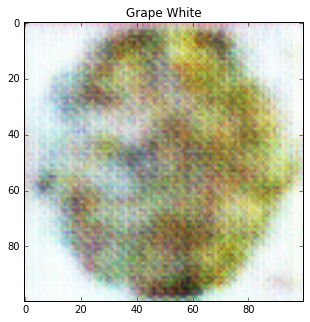

In [133]:
Show('k.png')
